In [1]:
%load_ext autoreload

In [2]:
%autoreload
from mine.models.mine import Mine
import torch.nn as nn
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import ceil
from einops import rearrange, repeat

Device: cuda


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224//5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 1000


# USE 100K TEST DATA
dataset = torchvision.datasets.ImageFolder(
    root='/scratch/network/ls1546/imagenet/ILSVRC/Data/CLS-LOC/test', 
    transform=transform
)

# # load part of dataset
# indices = torch.arange(20000)
# dataset_half = torch.utils.data.Subset(dataset, indices)
# dataloader = torch.utils.data.DataLoader(dataset_half, batch_size=batch_size, shuffle=True, num_workers=2)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

cuda:0


In [4]:
# image_dim = 224//5*224//5*3
image_dim = 224//5
mask_size = 4
weights = torch.zeros((image_dim, image_dim))
for i in range(0, image_dim, mask_size):
    for j in range(0, image_dim, mask_size):
        if (i // mask_size + j // mask_size) % 2 == 1:
            weights[i:i+mask_size, j:j+mask_size] = 3
# weights[ceil(image_dim/2-mask_size/2):ceil(image_dim/2+mask_size/2), ceil(image_dim/2-mask_size/2):ceil(image_dim/2+mask_size/2)] = 3

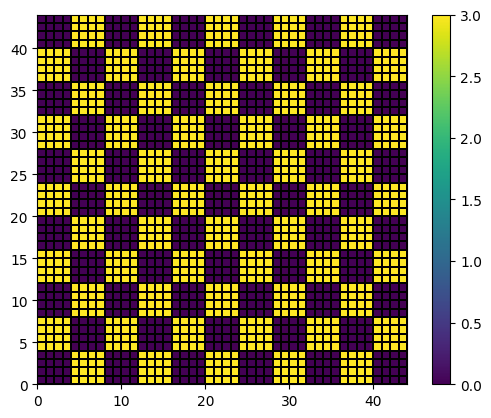

In [5]:
plt.figure()
plt.pcolormesh(weights, edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.show()

In [6]:
# weights[44,44] -> [44,44,0] -> [44,44,3] -> [1,5808]
flat_weights = np.repeat(weights.unsqueeze(0), 3, axis=0).view(1, -1)
flat_weights.shape

torch.Size([1, 5808])

In [7]:
# plt.imshow(np.repeat(weights.unsqueeze(-1), 3, axis=-1).flatten().view(44, 44, 3))
x = flat_weights.view(3, 224//5, 224//5)

In [8]:
def scale_rgb(x):
    return ((x - x.min()) / (x.max() - x.min()))

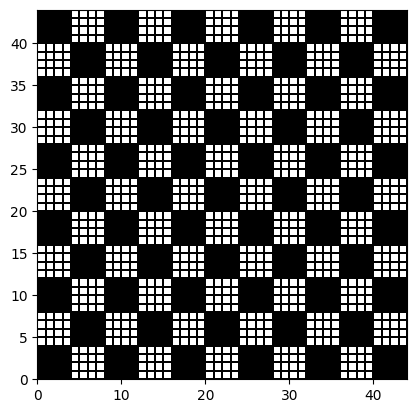

In [9]:
# weights are c w h
# need to flatten images in same way

plt.figure()
plt.pcolormesh(np.transpose(np.array(list(map(scale_rgb, x))), (1,2,0)), edgecolors='k', linewidth=0.005)
# plt.pcolormesh(np.array(list(map(scale_rgb, x))), edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.show()

In [10]:
# pass images through toy_network to get activations
class Toynetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(image_dim*image_dim*3, 1)
        self.fc1.weight = torch.nn.Parameter(flat_weights)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

In [11]:
toy_net = Toynetwork().to(device)

In [12]:
test = next(iter(dataloader))

In [13]:
test[0].shape
# images c w h

torch.Size([1000, 3, 44, 44])

In [14]:
# add hooks, run model with inputs to get activations

# a dict to store the activations
activation = {}
def get_activation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach().cpu().numpy()
        # activation[name] = output.numpy()
    return hook

hook = toy_net.fc1.register_forward_hook(get_activation('fc1'))

In [15]:
inputs_list = []
act_list = []

for inputs, _ in tqdm(dataloader):
    inputs = torch.flatten(inputs, start_dim=1)
    inputs = inputs.to(device)

    with torch.no_grad():
        output = toy_net(inputs)
        
        # collect the activations
        act_list.append(activation['fc1'])

        inputs = inputs.detach().cpu().numpy()
        inputs_list.append(inputs)

    del inputs

# detach the hooks
hook.remove()

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.17it/s]


In [16]:
# inputs_list = []
# act_list = []

# for inputs, _ in tqdm(dataloader):
#     inputs = torch.flatten(inputs, start_dim=1)
#     inputs = inputs.to(device)

#     with torch.no_grad():
#         output = toy_net(inputs)
        
#         # collect the activations
#         output = output.detach().cpu().numpy()
#         act_list.append(output)

#         inputs = inputs.detach().cpu().numpy()
#         inputs_list.append(inputs)

#     del inputs
#     del output

In [17]:
# send X=input images, Y=neuron responses to inputs into MINE, T's weights
# at 1st layer for X should approximate the  weights in toy_net

In [18]:
act_length = (len(act_list) - 1)*batch_size + len(act_list[len(act_list)-1])
act_length, len(act_list), act_list[0].shape, inputs_list[0].shape, inputs_list[-1].shape

(100000, 100, (1000, 1), (1000, 5808), (1000, 5808))

In [19]:
x = inputs_list[-1].copy()
x

array([[-0.23418105, -0.18280679, -0.09718303, ..., -1.4210021 ,
        -1.4384314 , -1.4732897 ],
       [ 0.00556549, -0.04580877, -0.09718303, ..., -0.82840955,
        -0.67154676, -0.54954237],
       [ 0.9131775 ,  0.9131775 ,  0.93030226, ...,  1.2805231 ,
         1.2979523 ,  1.2805231 ],
       ...,
       [ 1.2727973 ,  0.50218344, -0.78217316, ..., -1.7347276 ,
        -1.316427  , -0.54954237],
       [ 0.41655967,  0.09118938,  0.12543888, ..., -0.34039208,
        -0.28810447, -0.21838771],
       [-2.1007793 , -2.117904  , -2.117904  , ..., -0.13124175,
        -0.09638336, -0.14867094]], dtype=float32)

In [20]:
print(x.shape)
x = np.reshape(x[-1], (3, 224//5, 224//5))
print(x.shape)

(1000, 5808)
(3, 44, 44)


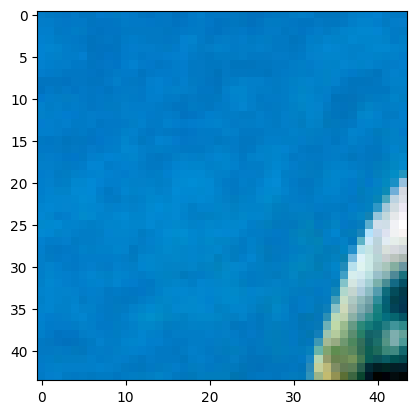

In [21]:
x[0] = scale_rgb(x[0])
x[1] = scale_rgb(x[1])
x[2] = scale_rgb(x[2])
plt.imshow(np.transpose(x, (1,2,0)))

In [22]:
samples = (len(inputs_list) - 1)*batch_size + len(inputs_list[len(inputs_list)-1])
images_flat = np.zeros((samples, (224//5)*(224//5)*3))
responses = np.zeros((act_length, 1))
x_dim=(224//5)*(224//5)*3
y_dim=1

for batch in range(len(act_list)):
    for image in range(len(act_list[batch])):
        responses[batch*len(act_list[0])+image, 0] = act_list[batch][image, 0]
        images_flat[batch*len(act_list[0])+image, :] = inputs_list[batch][image]

In [23]:
samples, act_length

(100000, 100000)

In [24]:
y = images_flat[-1].copy()
y.shape

(5808,)

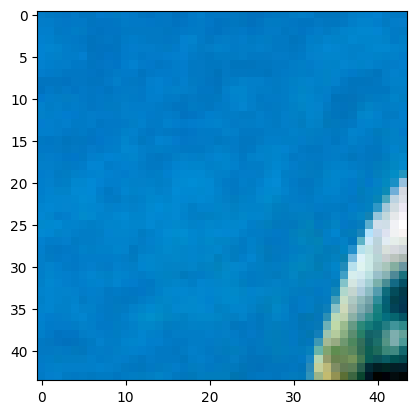

In [25]:
y = np.reshape(y, (3, 224//5, 224//5))
y[0] = scale_rgb(y[0])
y[1] = scale_rgb(y[1])
y[2] = scale_rgb(y[2])
plt.imshow(np.transpose(y, (1,2,0)))

In [26]:
del act_list, inputs_list

In [27]:
class Image_network(nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.fc1x = nn.Linear(x_dim, 1, bias=False)
        self.fc1y = nn.Linear(y_dim, 1, bias=False)
        self.fc2 = nn.Linear(2, 100, bias=False)
        self.fc3 = nn.Linear(100, 1, bias=False)

    def forward(self, x, y):
        x = F.relu(self.fc1x(x))
        y = F.relu(self.fc1y(y))
        h = torch.cat((x, y), dim=1)
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

In [28]:
device

device(type='cuda', index=0)

In [29]:
# image_network = torch.compile(image_network)
# print(device)
mine = Mine(
    T = Image_network(x_dim, y_dim),
    loss = 'mine', #mine_biased, fdiv
    device = device
).to(device)
lam = 0.005
mi, loss_log = mine.optimize(
    X=torch.tensor(images_flat, dtype=torch.float32), 
    Y=torch.tensor(responses, dtype=torch.float32), 
    epochs=5, 
    batch_size=batch_size, 
    lam=lam,
)

cuda:0


  0%|          | 0/5 [00:00<?, ?it/s]

0
tensor([0.4747], device='cuda:0')
tensor([0.4747], device='cuda:0')
tensor([0.4747], device='cuda:0')
tensor([0.4747], device='cuda:0')
tensor([0.4745], device='cuda:0')
tensor([0.4745], device='cuda:0')
tensor([0.4745], device='cuda:0')
tensor([0.4745], device='cuda:0')
tensor([0.4745], device='cuda:0')
tensor([0.4745], device='cuda:0')
tensor([0.4748], device='cuda:0')
tensor([0.4748], device='cuda:0')
tensor([0.4755], device='cuda:0')
tensor([0.4755], device='cuda:0')
tensor([0.4765], device='cuda:0')
tensor([0.4765], device='cuda:0')
tensor([0.4776], device='cuda:0')
tensor([0.4776], device='cuda:0')
tensor([0.4789], device='cuda:0')
tensor([0.4789], device='cuda:0')
tensor([0.4806], device='cuda:0')
tensor([0.4806], device='cuda:0')
tensor([0.4822], device='cuda:0')
tensor([0.4822], device='cuda:0')
tensor([0.4842], device='cuda:0')
tensor([0.4842], device='cuda:0')
tensor([0.4864], device='cuda:0')
tensor([0.4864], device='cuda:0')
tensor([0.4889], device='cuda:0')
tensor([0.48

In [ ]:
lam_str = str(lam)
lam_str

In [ ]:
plt.figure()
plt.plot(torch.stack(loss_log).detach().cpu().numpy())
plt.title("loss: checkerboard, 1000 epochs, lambda="+lam_str)
# plt.title("loss: square, 1000 epochs, lambda="+lam_str)
plt.ylabel("loss")
plt.xlabel("batches")
# plt.show()
plt.savefig("losscheck"+lam_str+".pdf")
# plt.savefig("losssq"+lam_str+".pdf")

In [ ]:
Tweights = mine.T.fc1x.weight.detach().cpu().numpy()[0]
Tweights.shape

In [ ]:
unflat_Tweights = np.reshape(Tweights, (3,224//5,224//5))
unflat_Tweights.shape

In [ ]:
for i in range(3):
    # plt.clf()
    plt.figure()
    plt.pcolormesh(scale_rgb(unflat_Tweights[i]), edgecolors="k", linewidth=0.005)
    ax = plt.gca()
    ax.set_aspect("equal")
    plt.colorbar()
    plt.title(f"check, lambda={lam_str}, channel {i}")
    plt.savefig(f"Tweightsc{i}{lam_str}check.pdf")

In [ ]:
plt.pcolormesh(np.transpose(np.array(list(map(scale_rgb, unflat_Tweights))), (1,2,0)), edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.title("check T weights combined channels, lambda="+lam_str)
plt.savefig("Tweightscombcheck" + lam_str + ".pdf")

plt.figure()
plt.pcolormesh(np.transpose(np.array(list(map(scale_rgb, flat_weights.view(3, 44, 44)))), (1,2,0)), edgecolors='k', linewidth=0.005)
# plt.pcolormesh(np.array(list(map(scale_rgb, x))), edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.show()

In [ ]:
np.save('images_flat_lam_check.npy', images_flat)
np.save('responses_lam_check.npy', responses)

In [ ]:
torch.save(mine.T, "mineTcheck" + lam_str + ".pth")
np.save("micheck" + lam_str + ".npy", mi.detach().cpu().numpy())
np.save("losscheck" + lam_str + ".npy", torch.stack(loss_log).detach().cpu().numpy())

In [ ]:
temp_mi = np.load("mi0.001.npy")

In [ ]:
temp_mi